In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


Imports

In [3]:
# Dataframe
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Embedding, Flatten, Conv1D, MaxPool1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Word2Vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', 
                   level = logging.INFO)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
print(stopwords.words('english'))
# words that take extra spaces in sentences , hence needs to be removed

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Settings

In [6]:
# dataset
dataset_col = ['target', 'ids', 'date', 'flag', 'user' , 'text']
dataset_encoding = 'ISO-8859-1'
train_size = 0.8

# text cleaning 
text_cleaning_re = '@\S+|https?:\S|[^A-Za-z0-9]+'

# word2vec
w2v_size = 300
w2v_window = 7
w2v_epoch = 32
w2v_min_count = 10

# keras
sequence_length = 300
epochs = 8
batch_size = 1024

# sentiment 
POSITIVE = 'POSITIVE'
NEGATIVE = 'NEGATIVE'
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLD = (0.4, 0.7)

# export
keras_model = 'model.h5'
word2vec_model = 'model.w2v'
tokenizer_model = 'tokenizer.pkl'
encoder_model = 'encoder.pkl'

Read Dataset

* target : polarity of tweet (0 -> negative, 2 -> neutral, 4 -> positive)
* text : the text in tweet

In [7]:
dataset_path = '/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(dataset_path, encoding = dataset_encoding, names = dataset_col)

In [8]:
df.shape

(1600000, 6)

In [9]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Data Preprocessing

Mapping target values to corresponding sentiments

In [10]:
decode_map = {0 : NEGATIVE, 2 : NEUTRAL, 4 : POSITIVE}
def decode_sentiment(label):
    return decode_map[int(label)]

In [11]:
df.target = df.target.apply(lambda x : decode_sentiment(x))

Text(0.5, 1.0, 'Dataset label distribution')

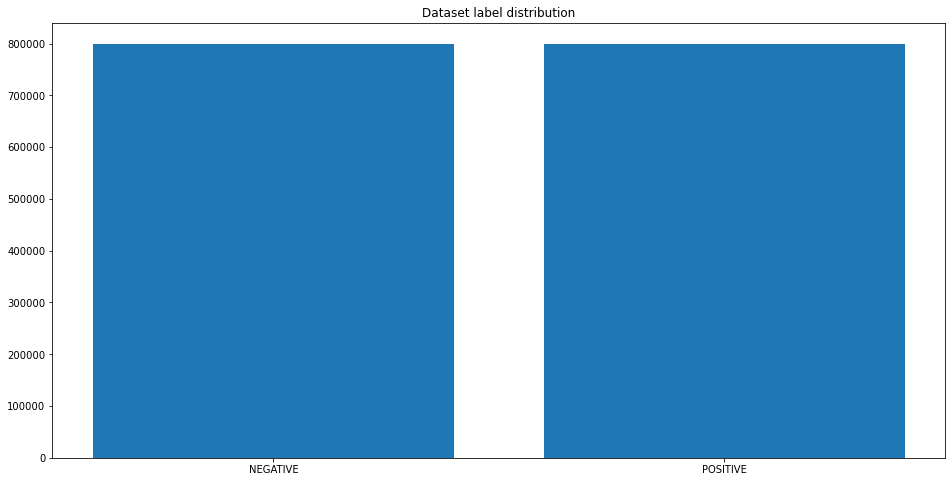

In [12]:
target_cnt = Counter(df.target)

plt.figure(figsize = (16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title('Dataset label distribution')

* Removing link (http), users, special char (@,etc)
* Removing stopwords
* Stemming

In [13]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [14]:
def preprocess(text, stem = False):
    # removing link, user, special char
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return ' '.join(tokens)            

In [15]:
df.text = df.text.apply(lambda x : preprocess(x))

In [16]:
df.head(5)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,twitpic com 2y1zl awww bummer shoulda got davi...
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see


Split train test sets

In [17]:
df_train, df_test = train_test_split(df, test_size = 1 - train_size, random_state = 42)

In [18]:
df_train.shape

(1280000, 6)

In [19]:
df_test.shape

(320000, 6)

Word to Vector : Word2Vec

In [20]:
documents = []
for _sentences in df_train.text:
    documents.append(_sentences.split())

In [21]:
documents

[['ya',
  'quot',
  'like',
  'palm',
  'pre',
  'touchstone',
  'charger',
  'readynow',
  'yes',
  'sounds',
  'good',
  'beer',
  'ready',
  'prelaunch'],
 ['felt', 'earthquake', 'afternoon', 'seems', 'epicenter'],
 ['ruffles', 'shirts', 'like', 'likey'],
 ['pretty',
  'bad',
  'night',
  'crappy',
  'morning',
  'fml',
  'buttface',
  'didnt',
  'say',
  'could',
  'go',
  'work',
  'today'],
 ['yeah', 'clear', 'view'],
 ['one',
  'time',
  'follow',
  'fam',
  'ff',
  'georgeann13',
  'nakithebeatman',
  'flimackgod',
  'chaz81',
  'djt',
  'elle',
  'jaejaedynomite',
  'welcome',
  'friday',
  'follow',
  '2'],
 ['u', 'rock', 'thanks', 'added', 'next', 'robcrotch', 'tm', 'video'],
 ['yes',
  'please',
  'met',
  'fiancee',
  'ian',
  'party',
  'day',
  'btw',
  'sweet',
  'congrats',
  'guys'],
 ['gawd',
  'finished',
  'whole',
  'bowl',
  'even',
  'posted',
  'previous',
  'tweet',
  'making',
  '2nd',
  'bowl'],
 ['awesome', 'game', 'short', 'finish', 'craving', 'god', 'war'

Gensim is an open source python library for natural language processing and it was developed and is maintained by the Czech natural language processing researcher Radim Řehůřek. Gensim library will enable us to develop word embeddings by training our own word2vec models on a custom corpus either with CBOW of skip-grams algorithms.

In [22]:
w2v_model = gensim.models.word2vec.Word2Vec(size = w2v_size,
                                           window = w2v_window,
                                           min_count= w2v_min_count,
                                           workers = 8)

In [23]:
w2v_model.build_vocab(documents)

In [24]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)

In [25]:
words

dict_keys(['ya', 'quot', 'like', 'palm', 'pre', 'charger', 'yes', 'sounds', 'good', 'beer', 'ready', 'prelaunch', 'felt', 'earthquake', 'afternoon', 'seems', 'shirts', 'likey', 'pretty', 'bad', 'night', 'crappy', 'morning', 'fml', 'didnt', 'say', 'could', 'go', 'work', 'today', 'yeah', 'clear', 'view', 'one', 'time', 'follow', 'fam', 'ff', 'elle', 'welcome', 'friday', '2', 'u', 'rock', 'thanks', 'added', 'next', 'tm', 'video', 'please', 'met', 'fiancee', 'ian', 'party', 'day', 'btw', 'sweet', 'congrats', 'guys', 'gawd', 'finished', 'whole', 'bowl', 'even', 'posted', 'previous', 'tweet', 'making', '2nd', 'awesome', 'game', 'short', 'finish', 'craving', 'god', 'war', 'action', 'happy', 'mothers', 'grown', 'n', 'amp', 'lil', 'prego', 'lol', 'playing', 'everyone', 'loved', 'bless', 'back', 'eating', 'dinner', 'chat', 'room', 'many', 'heck', 'way', 'heights', 'want', 'trade', 'tired', 'saying', 'goodbye', 'chicago', 'stole', 'half', '12', 'mai', 'tai', 'inbound', 'suddenly', 'trouble', 'rel

In [26]:
vocab_size

30611

In [27]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs = w2v_epoch)

CPU times: user 20min 48s, sys: 6.94 s, total: 20min 55s
Wall time: 11min 52s


(267043821, 301067232)

In [37]:
w2v_model.most_similar('morning')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('mornin', 0.6177557706832886),
 ('morn', 0.6166998744010925),
 ('afternoon', 0.5959452390670776),
 ('day', 0.5285569429397583),
 ('goodmorning', 0.5219192504882812),
 ('moring', 0.4794486463069916),
 ('today', 0.47924304008483887),
 ('evening', 0.47678929567337036),
 ('sunday', 0.46797189116477966),
 ('8am', 0.4421433210372925)]

Tokenize text and Padding

In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index)+1

In [41]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen = sequence_length)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen = sequence_length)

In [42]:
x_train.shape

(1280000, 300)

In [43]:
x_test.shape

(320000, 300)

Label Encoding

In [44]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [45]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [46]:
print(x_train.shape)
print(y_train.shape)

(1280000, 300)
(1280000, 1)


In [47]:
print(x_test.shape)
print(y_test.shape)

(320000, 300)
(320000, 1)


In [48]:
y_train

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [50]:
x_train[:1]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

Embedding Layer

In [51]:
embedding_matrix = np.zeros((vocab_size, w2v_size))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [54]:
embedding_matrix[:,:1]

array([[ 0.        ],
       [-1.47110176],
       [-1.12773311],
       ...,
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [56]:
embedding_layer = Embedding(vocab_size, w2v_size, weights = [embedding_matrix], 
                            input_length = sequence_length, trainable = False)

Model Building

In [57]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          102306000 
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 102,466,501
Trainable params: 160,501
Non-trainable params: 102,306,000
_________________________________________________________________


In [58]:
model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

Callbacks

In [59]:
callbacks = [ReduceLROnPlateau(monitor = 'val_loss', patience = 5, cooldown = 0),
            EarlyStopping(monitor = 'val_accuracy', min_delta = 1e-4, patience = 5)]

Train

In [60]:
history = model.fit(x_train, y_train,
                   batch_size = batch_size,
                   epochs = epochs,
                   validation_split= 0.1,
                   verbose=1,
                   callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 556s 494ms/step - loss: 0.5064 - accuracy: 0.7488 - val_loss: 0.4668 - val_accuracy: 0.7795
Epoch 2/8
1125/1125 [==============================] - 557s 495ms/step - loss: 0.4793 - accuracy: 0.7675 - val_loss: 0.4600 - val_accuracy: 0.7833
Epoch 3/8
1125/1125 [==============================] - 558s 496ms/step - loss: 0.4722 - accuracy: 0.7716 - val_loss: 0.4542 - val_accuracy: 0.7860
Epoch 4/8
1125/1125 [==============================] - 556s 494ms/step - loss: 0.4681 - accuracy: 0.7747 - val_loss: 0.4514 - val_accuracy: 0.7876
Epoch 5/8
1125/1125 [==============================] - 556s 495ms/step - loss: 0.4653 - accuracy: 0.7759 - val_loss: 0.4485 - val_accuracy: 0.7892
Epoch 6/8
1125/1125 [==============================] - 557s 495ms/step - loss: 0.4633 - accuracy: 0.7773 - val_loss: 0.4486 - val_accuracy: 0.7900
Epoch 7/8
1125/1125 [==============================] - 558s 496ms/step - loss: 0.4620 - accuracy: 0.7781 - val_loss: 0

Evaluate

In [61]:
score = model.evaluate(x_test, y_test, batch_size = batch_size)
print(score)

313/313 [==============================] - 52s 166ms/step - loss: 0.4441 - accuracy: 0.7919
[0.444121390581131, 0.7919343709945679]


Accuracy , Loss plot during train

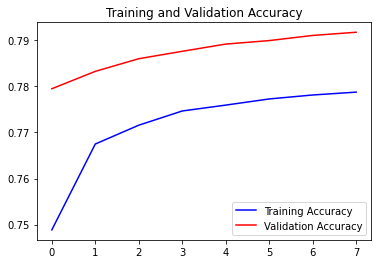

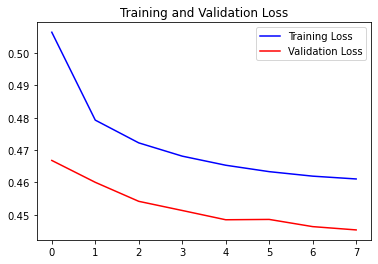

In [64]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

# accuracy
plt.figure()
plt.plot(epochs, accuracy, 'b', label = 'Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

#loss
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

Predictions

In [65]:
def decode_sentiment(score, include_neutral = True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLD[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLD[1]:
            label = POSITIVE
        
        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [66]:
def predict(text, include_neutral = True):
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = sequence_length)
    # predict score
    score = model.predict([x_test])[0]
    # decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)
    return {"label" : label,
           "score" : float(score)}
    

In [67]:
predict('Hello World!!')

{'label': 'POSITIVE', 'score': 0.9894318580627441}

In [68]:
predict('Bye Bye')

{'label': 'NEUTRAL', 'score': 0.48731911182403564}

In [69]:
predict('I am gonna leave')

{'label': 'NEGATIVE', 'score': 0.21064524352550507}

In [76]:
predict('I just lost again')

{'label': 'NEGATIVE', 'score': 0.036546602845191956}

Confusion matrix

In [77]:
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1,batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 39s 977ms/step


In [82]:
def plot_confusion_matrix(cm, classes,title = 'Confusion Matrix', cmap = plt.cm.Blues):
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 90, fontsize = 22)
    plt.yticks(tick_marks, classes, fontsize = 22)
    
    
    fmt = '.2f'
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j], fmt),
                horizontalalignment = 'center',
                color = 'white' if cm[i,j] > thresh else 'black')
    
    plt.ylabel('True label', fontsize = 25)
    plt.xlabel('Predicted label', fontsize = 25)
    

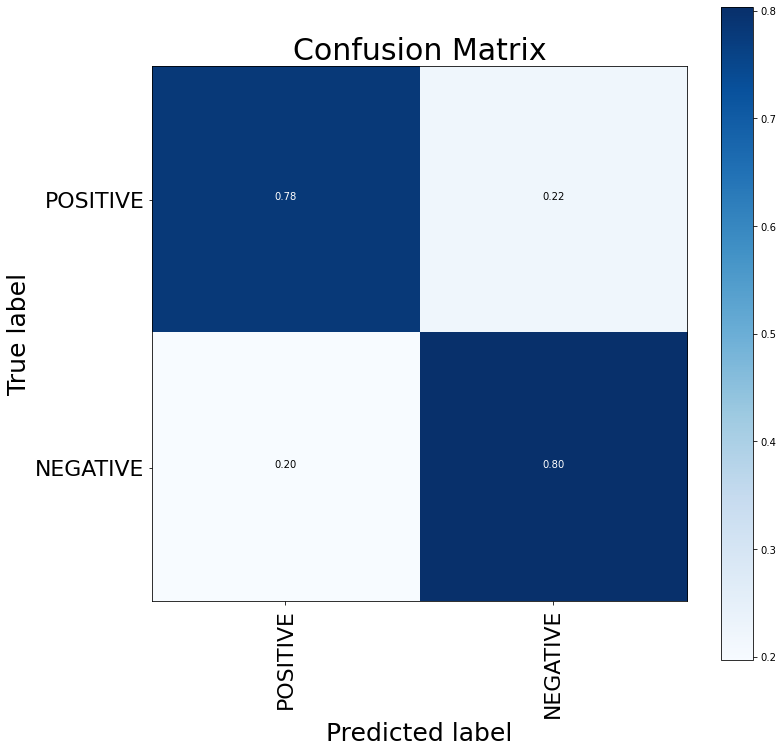

In [83]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes = df_train.target.unique(), title = 'Confusion Matrix')
plt.show()

In [84]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [ ]:
accuracy_score(y_test_1d, y_pred_1d)